In [1]:
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages

# Install Bioconductor's DirichletMultinomial package if not installed
if not rpackages.isinstalled("BiocManager"):
    ro.r("install.packages('BiocManager')")

if not rpackages.isinstalled("DirichletMultinomial"):
    ro.r("BiocManager::install('DirichletMultinomial')")

if not rpackages.isinstalled("reshape2"):
    ro.r("install.packages('reshape2')")

ℹ Using R 4.1.1 (lockfile was generated with R 4.2.3)
- Project '~/Desktop/dan/prj_mac/infant_microbiome_hmm/code' loaded. [renv 1.1.2]
- The project is out-of-sync -- use `renv::status()` for details.


In [2]:
# import dataset
# import importlib
# importlib.reload(dataset)
# from dataset import InfantMicrobiomeDataset

In [ ]:
# import gaussianhmm
# import importlib
# importlib.reload(gaussianhmm)
# from gaussianhmm import InfantMBGaussianHMM

In [3]:
import pandas as pd
import numpy as np
import os

from dataset import InfantMicrobiomeDataset
from gaussianhmm import InfantMBGaussianHMM

from mylogger import logger # this import creates "output" dir & .log file

# logger needs to be reimported if output directory needs to be created again
# import mylogger
# import importlib
# importlib.reload(mylogger)
# from mylogger import logger


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

R[write to console]: 필요한 패키지를 로딩중입니다: S4Vectors

R[write to console]: 필요한 패키지를 로딩중입니다: stats4

R[write to console]: 필요한 패키지를 로딩중입니다: BiocGenerics

R[write to console]: 
다음의 패키지를 부착합니다: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


R[write to console]: 
다음의 패키지를 부착합니다: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    I, expand.grid, unname


R[write to console]: 필요한 패키지를 로딩중입니다: IRanges



In [4]:
otu_df = pd.read_csv('ignore/merged_otu.csv',index_col="Taxa")
label_df = pd.read_csv('data/class_labels.tsv',delimiter='\t',index_col="Astarte ID")

In [5]:
dataset = InfantMicrobiomeDataset(otu_df.copy(deep=True), label_df)

Label missing for sample id: <1242> 
=> not added to dictionary dataset
sample id: <1242> removed from microbiome data

Label missing for sample id: <1078> 
=> not added to dictionary dataset
sample id: <1078> removed from microbiome data

Label missing for sample id: <1023> 
=> not added to dictionary dataset
sample id: <1023> removed from microbiome data

Label missing for sample id: <1128> 
=> not added to dictionary dataset
sample id: <1128> removed from microbiome data

Label missing for sample id: <2018> 
=> not added to dictionary dataset
sample id: <2018> removed from microbiome data

Label missing for sample id: <2017> 
=> not added to dictionary dataset
sample id: <2017> removed from microbiome data



In [6]:
# Perform leave-one-out cross validation (loocv) where each infant will be test data once; 
# => perform classification on each sample by looping through each infant

outdir='output/'

true_ls = []
loglikelihood_ratio_ls = []
test_infant_id_ls = []

pseudo_cnt = 10

gf_n_components = 4
gn_n_components = 4

for idx, sample_id in enumerate(dataset.data_dict.keys()):
    random_state = idx
    print(f"{idx}th loocv iteration")

    # train/test split (for LOOCV, test data = single infant)
    dataset.train_test_split(sample_ids=[sample_id], random_state=random_state) 

    # split TRAIN data by label (remove missing tps)
    gf_df = dataset.get_single_class_df(is_label_1=True, remove_missing_tps=True, from_train=True)
    gn_df = dataset.get_single_class_df(is_label_1=False, remove_missing_tps=True, from_train=True)

    # drop rows (taxa) with less than n observed datapoints in gf/gn df 
    idx_to_drop_gf = dataset.get_idx_w_less_than_n_datapoints(gf_df, unobserved_val=0, n=3)
    idx_to_drop_gn = dataset.get_idx_w_less_than_n_datapoints(gn_df, unobserved_val=0, n=3)

    idx_to_drop = idx_to_drop_gf+idx_to_drop_gn
    gf_df = gf_df.drop(index=idx_to_drop)
    gn_df = gn_df.drop(index=idx_to_drop)
    logger.info(f"gf data shape: <{gf_df.shape}>")
    logger.info(f"gn data shape: <{gn_df.shape}>")

    # add pseudo counts before running DMM
    gf_df = dataset.add_pseudo_cnt(gf_df, pseudo_cnt=pseudo_cnt)
    gn_df = dataset.add_pseudo_cnt(gn_df, pseudo_cnt=pseudo_cnt)

    # save gf_df & gn_df csv files for DMM code to access
    infant_dir_path = outdir+f"{sample_id}/"
    os.mkdir(infant_dir_path)
    gf_df.to_csv(infant_dir_path+"gf.csv")
    gn_df.to_csv(infant_dir_path+"gn.csv")

    # run DMM on each class-split & save initial state assignments to infant_dir_path
    dataset.run_dmm(out_dir=infant_dir_path,
                    data_path=infant_dir_path+"gf.csv",
                    n_comp_range_pair=(gf_n_components,gf_n_components),
                    random_state=random_state)

    dataset.run_dmm(out_dir=infant_dir_path,
                    data_path=infant_dir_path+"gn.csv",
                    n_comp_range_pair=(gn_n_components,gn_n_components),
                    random_state=random_state)

    # creat new df with missing tp & transform data to proability (by samples) & center log ratio 
    gf_w_missing_df = dataset.get_single_class_df(is_label_1=True, remove_missing_tps=False, from_train=True)
    gn_w_missing_df = dataset.get_single_class_df(is_label_1=False, remove_missing_tps=False, from_train=True)

    # drop rows (taxa) with less than n observed datapoints in gf/gn df  
    gf_w_missing_df = gf_w_missing_df.drop(index=idx_to_drop)
    gn_w_missing_df = gn_w_missing_df.drop(index=idx_to_drop)

    # add pseudo counts to data with missing timepoint columns
    gf_w_missing_df = dataset.add_pseudo_cnt(gf_w_missing_df, pseudo_cnt=pseudo_cnt)
    gn_w_missing_df = dataset.add_pseudo_cnt(gn_w_missing_df, pseudo_cnt=pseudo_cnt)

    gf_clr_df = dataset.normalize_n_clr(gf_w_missing_df, norm_col=True)
    gn_clr_df = dataset.normalize_n_clr(gn_w_missing_df, norm_col=True)

    # create GF & GN HMM model instances
    # & initialize HMM params (initial/transition/emission) from assigned states
    gf_hmm = InfantMBGaussianHMM(n_states=gf_n_components, name='gf_hmm')
    gn_hmm = InfantMBGaussianHMM(n_states=gn_n_components, name='gn_hmm')

    gf_hmm.initialize_hmm_params_from_state_assignments(data_df = gf_clr_df,
                                                        sa_path = infant_dir_path+"gf_state_assignments.csv")

    gn_hmm.initialize_hmm_params_from_state_assignments(data_df = gn_clr_df,
                                                        sa_path = infant_dir_path+"gn_state_assignments.csv")
    # create dict version of data for HMM
    gf_hmm.data_dict = dataset.create_data_dict(gf_clr_df)
    gn_hmm.data_dict = dataset.create_data_dict(gn_clr_df)

    # fit on train data
    gf_hmm.fit(gf_hmm.data_dict)
    gn_hmm.fit(gn_hmm.data_dict)

    # get predictions on test set
    # *perform the same preprocessing on test dataset
    dataset.test_df = dataset.test_df.drop(index=idx_to_drop)
    dataset.test_df = dataset.add_pseudo_cnt(dataset.test_df, pseudo_cnt=pseudo_cnt)
    test_clr_df= dataset.normalize_n_clr(dataset.test_df, norm_col=True)

    test_dict = dataset.create_data_dict(test_clr_df)

    gf_loglikelihood_dict = gf_hmm.calc_loglikelihood(test_dict)
    gn_loglikelihood_dict = gn_hmm.calc_loglikelihood(test_dict)

    for sample_id, data in dataset.test_dict.items():
        test_infant_id_ls.append(sample_id)
        true_ls.append(data.label)
        loglikelihood_ratio_ls.append(gf_loglikelihood_dict[sample_id] - gn_loglikelihood_dict[sample_id])

    logger.info(f"Test infant id list: {str(test_infant_id_ls)}")
    logger.info(f"True label list: {str(true_ls)}")
    logger.info(f"Loglikelihood_ratio list: {str(loglikelihood_ratio_ls)}")


0th loocv iteration

  Soft kmeans
    iteration 10 change 0.054608
    iteration 20 change 0.000138
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.268790
  Hessian

  Soft kmeans
    iteration 10 change 0.013045
    iteration 20 change 0.000371
    iteration 30 change 0.000006
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 6.446044
  Hessian
1th loocv iteration

  Soft kmeans
    iteration 10 change 0.021116
    iteration 20 change 0.001933
    iteration 30 change 0.000002
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.004788
  Hessian

  Soft kmeans
    iteration 10 change 0.005655
    iteration 20 change 0.014335
    iteration 30 change 0.000653
    iteration 40 change 0.000001
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.000000
  Hessian
2th loocv iteration

  Soft kmeans
    iteration 10 change 0.104736
    iteration 20 change 

In [7]:
ll_arr = np.array(loglikelihood_ratio_ls)
pred_arr = np.where(ll_arr>0,1,0)
true_arr = np.array(true_ls)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc = accuracy_score(true_arr, pred_arr)
prec = precision_score(true_arr, pred_arr)
rec = recall_score(true_arr, pred_arr)
f1 = f1_score(true_arr, pred_arr)
cm = confusion_matrix(true_arr, pred_arr)

# Print them
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Accuracy: 0.5938697318007663
Precision: 0.4583333333333333
Recall: 0.4489795918367347
F1 Score: 0.45360824742268036
Confusion Matrix:
 [[111  52]
 [ 54  44]]


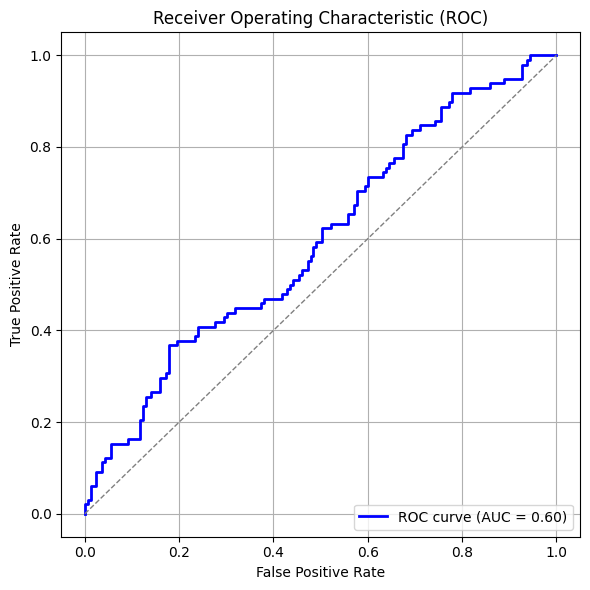

In [10]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(true_ls, loglikelihood_ratio_ls)

# Compute AUC (area under the curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()